In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from reconstruction import Model, TopKLayer
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import synthesizer
import os
import itertools
from torch import optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [3]:
def getImage(img_path, p, epochs=100):
    m = Model(img_path, topk=p['topk'], device=p['device'], dimensions=p['dimensions'], reverse_topk=p['reverse_topk'])
    I = torch.rand((1, 3, m.dimensions[0], m.dimensions[1])).to(device)
    I = I.requires_grad_(True)
    optimizer = optim.LBFGS([I], lr=1)

    r = 0
    while r < epochs:
        def closure():
            optimizer.zero_grad()
            I.grad = None
            m(I)
            loss = m.loss()
            loss.backward(retain_graph=True)
            #print(f'I gradient: {I.grad}')
            return loss
        optimizer.step(closure)

        r += 1
        print(f'\rEpoch {r}: Loss {m.loss().item()}', end='')
    print()
    return I

In [4]:
img_name = 'rocks'
img_ext = '.jpg'
img_path = os.path.join('./', img_name + img_ext)
parameters = {
    'topk': 0.05,
    'device': device,
    'dimensions': (500, 500), 
    'reverse_topk': True
}
print(img_path)

./rocks.jpg


In [6]:
topks = [0.05, 0.5, 0.95]
reverses = [True, False]

for p in itertools.product(topks, reverses):
    parameters['topk'] = p[0]
    parameters['reverse_topk'] = p[1]
    print(p)

    I = getImage(img_path, parameters, epochs=100)
    transforms.ToPILImage()(np.clip(I.clone().detach().cpu().squeeze(0).numpy().transpose(1, 2, 0), 0, 1)).save(os.path.join('./results', f'{img_name}-{p[0]}-{p[1]}{img_ext}'))

(0.05, True)
Epoch 100: Loss 573871.3125
(0.05, False)
Epoch 100: Loss 94936.0312555
(0.5, True)
Epoch 100: Loss 781918.125
(0.5, False)
Epoch 100: Loss 63497.26953125
(0.95, True)
Epoch 100: Loss 57529.26171875
(0.95, False)
Epoch 100: Loss 5877.5810546875


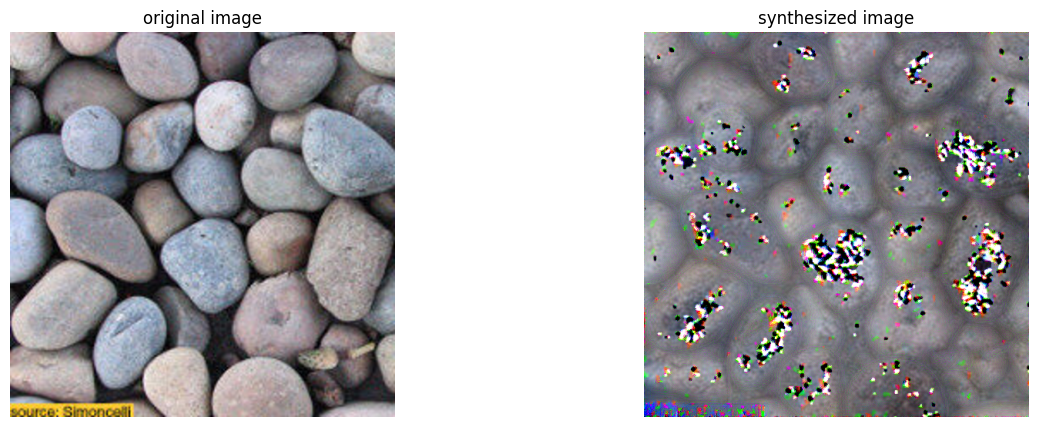

In [30]:
img = np.clip(I.clone().detach().cpu().squeeze(0).numpy().transpose(1, 2, 0), 0, 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(Image.open(img_path).resize(m.dimensions))
ax1.axis('off')
ax1.set_title('original image')
ax2.imshow(img)
ax2.axis('off')
ax2.set_title('synthesized image')
plt.savefig('oh-man.png')
plt.show()